In [9]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import math
import matplotlib.pyplot as plt

In [10]:
#training a two layer NN for MNIST with label noise with distance to initialization regularization

#SETTING DIFFERENCE THAN THEORY in S.Satpathi,H.Gupta,S.Liang,andR.Srikant,“The role of regularization
#in overparameterized neural networks,”2020 :: x is not normalized

In [11]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('./data/train', download=True, train=True, transform=transform)

valset = datasets.MNIST('./data/test', download=True, train=False, transform=transform)

#ONLY selecting digits 0 and 1 two classes

idx_train = trainset.targets==0
idx_train +=trainset.targets==1
idx_test = valset.targets==0
idx_test += valset.targets==1
idx_train = torch.squeeze(torch.nonzero(idx_train))
idx_test = torch.squeeze(torch.nonzero(idx_test))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(idx_train), sampler = torch.utils.data.SubsetRandomSampler(idx_train))

valloader = torch.utils.data.DataLoader(valset, batch_size=len(idx_train), sampler = torch.utils.data.sampler.SubsetRandomSampler(idx_test))

In [12]:
print("Total number of data poits=", len(idx_train))

Total number of data poits= 12665


Linear(in_features=10000, out_features=1, bias=True)
tensor(1.6075, device='cuda:0', grad_fn=<MseLossBackward>)


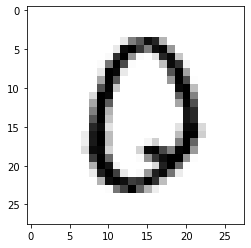

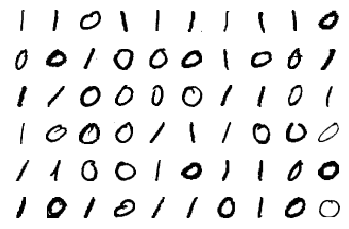

In [13]:
hidden_size = 10000 #(= m = width of network)
restrict = 10000 #(= n =number of data points chosen for training)


##################################################DEFINE THE NETWORK##################################
input_size = 784

m = hidden_size
d = input_size
n = restrict

def init_weights(l):
    if type(l) == nn.Linear:
        torch.nn.init.normal_(l.weight,mean = 0,std = 1/28)
        l.bias.data.fill_(0)
def init_weights1(l,m):
    torch.nn.init.uniform_(l.weight,-1/math.sqrt(m), 1/math.sqrt(m))
    l.bias.data.fill_(0)
    
model = nn.Sequential(nn.Linear(input_size, hidden_size),nn.ReLU(),
                      nn.Linear(hidden_size,1))
model[0].apply(init_weights)#Gaussian weights in first layer
model[2].apply(lambda x: init_weights1(x,m))#uniform weights in second layer, 1/math.sqrt(m) scaling
for layer,child in enumerate(model.children()):#freeze training of second layer
    if layer == 2:
        print(child)
        for param in child.parameters():
            param.requires_grad = False

dataiter = iter(trainloader)
images, labels = dataiter.next()
plt.imshow((images[0]/2+0.5).numpy().squeeze(), cmap='gray_r');
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow((images[index]/2+0.5).numpy().squeeze(), cmap='gray_r')

            
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


#############################################READ AND PREPROCESS THE DATA############################

#add noise to the labels
def flip(labels,sigma):
    return labels + sigma*labels*(torch.rand_like(labels))

criterion = nn.MSELoss()
images, labels = next(iter(trainloader))
images = images.to(device) 
labels = labels.to(device)
images = images[:restrict]
labels = labels[:restrict]


labels = 2*(labels.float() -0.5)
images = images.view(images.shape[0], -1)
labels = flip(labels,1)#adding noise to labels

images_test, labels_test = next(iter(valloader))
images_test = images_test.to(device)
labels_test = labels_test.to(device)
images_test = images_test.view(images_test.shape[0], -1)
labels_test = 2*(labels_test.float() -0.5)

loss = criterion(torch.squeeze(model(images_test)), labels_test) 
print(loss)

torch.save(model,'model.pt')

In [16]:
epochs = 1000
regularizer = [0,0.1,4,10]
##TAKES about 5 minutes to run
###############################################TRAIN THE NETWORK#####################################
stat = {}
for lam in regularizer:
    model = torch.load('model.pt')#each run with lambda has same initialization
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    time0 = time()
    weight0 = model[0].weight.data.clone().detach()#save the weight
    for e in range(epochs):
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(torch.squeeze(output), labels)
        loss += lam*torch.norm(model[0].weight - weight0)**2 #addition of regularization
        #This is where the model learns by backpropagating
        loss.backward()

        #And optimizes its weights here
        optimizer.step()

        with torch.no_grad():
            train_loss = loss.item() 
            test_loss = criterion(torch.squeeze(model(images_test)), labels_test).item()
            weight_norm = torch.norm(model[0].weight.data)
            weight_weight0_norm = torch.norm(model[0].weight.data - weight0)
            if e==0:
                grad0 = model[0].weight.grad.clone().detach()
                train_stat = np.array([train_loss,weight_weight0_norm,weight_norm,test_loss,0])
            else:
                grad_grad0 = torch.norm(model[0].weight.grad - grad0)
                train_stat = np.vstack((train_stat,[train_loss,weight_weight0_norm,weight_norm,test_loss,grad_grad0]))
    print("\nTraining Time (in minutes) =",(time()-time0)/60,' and lambda = ',lam)
    stat[lam] = train_stat
torch.save(stat,'MNISTtrainstat.pt')


Training Time (in minutes) = 1.6974922299385071  and lambda =  0

Training Time (in minutes) = 2.031114701430003  and lambda =  0.1

Training Time (in minutes) = 1.2372933348019919  and lambda =  4

Training Time (in minutes) = 0.11512690385182699  and lambda =  10


 
 TRAINING LOSS 

0.11541484296321869  lambda =  0
0.1797846555709839  lambda =  0.1
0.767686128616333  lambda =  4
1.4245696067810059  lambda =  10
 
 TEST LOSS 

0.2615411877632141  lambda =  0
0.24664035439491272  lambda =  0.1
0.09340221434831619  lambda =  4
0.16142286360263824  lambda =  10


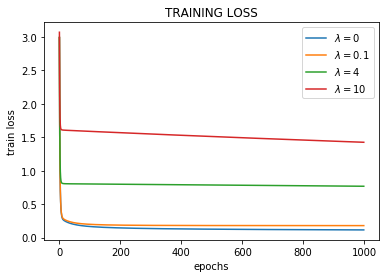

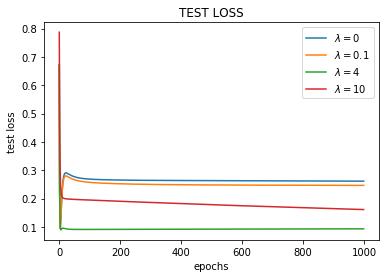

In [18]:
l = 0 #starting epoch to plot
h = epochs #ending epoch to plot
#######################VISUALIAZING THE RESTULS###################################

print(' \n TRAINING LOSS \n')
plt.figure(0)
for i in stat:
    s = '$\lambda='+str(i)+'$'
    train_stat = stat[i]
    plt.plot(list(range(l,h)), train_stat[l:h,0],label = s)
    print(train_stat[-1,0],' lambda = ',i)
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.legend()
plt.title('TRAINING LOSS')
plt.savefig('train_loss.png')


plt.figure(1)
print(' \n TEST LOSS \n')
for i in stat:
    s = '$\lambda='+str(i)+'$'
    train_stat = stat[i]
    plt.plot(list(range(l,h)), train_stat[l:h,3],label = s)
    print( train_stat[-1,3],' lambda = ',i)
plt.ylabel('test loss')
plt.xlabel('epochs')
plt.legend()
plt.title('TEST LOSS')
plt.savefig('test_loss.png')
